# Self Organizing Systems - Metro Maps Vizualisation
### Stella Mahler: 11936014 Janek Janßen: 51829460

### https://github.com/flurputzer/SOS_MetroMaps

This notebook implements a metromap visualization for self-organizing maps, following the paper http://www.ifs.tuwien.ac.at/~mayer/publications/pdf/NEU07_ijcnn.pdf by Robert Neumayer, Rudolf Mayer, Georg Pölzlbauer and Andreas Rauber.

The code is an adaptation of the SOMToolBox Java implementation.

# SomToolBox Vizualisations Comparison


### Left: SomToolBox
### <div style="text-align: right">Right: Python </div>

### Hint: comparing the actual image files included in the repository is easier

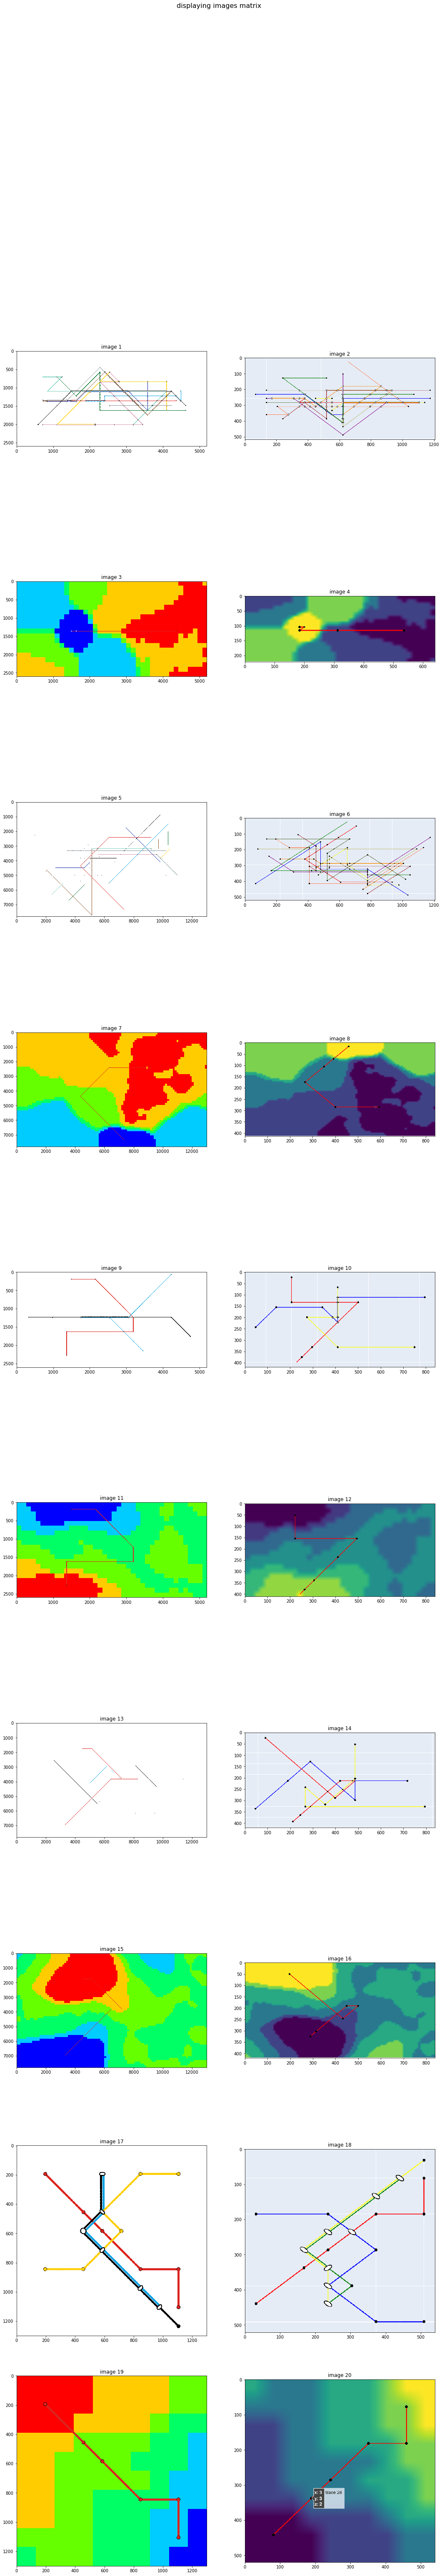

In [250]:
import matplotlib.pyplot as plt
#10clusters40x20
img1 = plt.imread('viz/10clusters/MetroMap40x20.png')
img2 = plt.imread('viz/10clusters/python/Python40x20.png')
#10clusters40x20_comp1
img3 = plt.imread('viz/10clusters/MetroMap40x20_Comp1.png')
img4 = plt.imread('viz/10clusters/python/Python40x20_Comp1.png')


#10clusters100x60
img5 = plt.imread('viz/10clusters/MetroMap100x60_6bins.png')
img6 = plt.imread('viz/10clusters/python/Python100x60.png')
#10clusters100x60_comp1
img7 = plt.imread('viz/10clusters/MetroMap100x60_6bins_Comp1.png')
img8 = plt.imread('viz/10clusters/python/Python100x60_Comp1.png')

#chainlink40x20
img9 = plt.imread('viz/chainlink/MetroMap40x20_6bins.png')
img10 = plt.imread('viz/chainlink/python/Python40x20.png')
#chainlink40x20_comp1a
img11 = plt.imread('viz/chainlink/MetroMap40x20_6bins_comp1.png')
img12 = plt.imread('viz/chainlink/python/Python40x20_Comp1.png')


#chainlink100x60
img13 = plt.imread('viz/chainlink/MetroMap100x60_6bins.png')
img14 = plt.imread('viz/chainlink/python/Python100x60.png')
#chainlink100x60_comp1
img15 = plt.imread('viz/chainlink/MetroMap100x60_6bins_comp1.png')
img16 = plt.imread('viz/chainlink/python/Python100x60_Comp1.png')

#iris
img17 = plt.imread('viz/iris/MetroMap_6bins.png')
img18 = plt.imread('viz/iris/python/Python.png')
#iris_comp1
img19 = plt.imread('viz/iris/MetroMap_6bins_comp1.png')
img20 = plt.imread('viz/iris/python/Python_Comp1.png')



images = [img1, img2,img3, img4,img5, img6,img7, img8, img9, img10 ,img11, img12,img13, img14,img15, img16,img17, img18,img19, img20]

NUM_ROWS = 10
IMGs_IN_ROW = 2

f, ax_arr = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(18,100))

for j, row in enumerate(ax_arr):
    for i, ax in enumerate(row):
        ax.imshow(images[j*IMGs_IN_ROW+i])
        ax.set_title(f'image {j*IMGs_IN_ROW+i+1}')

#title = 'displaying images matrix'
f.suptitle(title, fontsize=16)
plt.show() 

# Run code from here
### Update paths and parameter

In [257]:
path_weight_file = 'maps/iris/iris.wgt.gz' #.wgt or .wgt.gz
#path_weight_file = 'iris.wgt.gz' #.wgt or .wgt.gz
no_of_bins = 6 #examples  integer 6
components_selected = None # example [0,3,4], None to choose all components
component_for_background_vis = 1 # integer example: 3
interpolate = 'best'  # False, 'best', 'fast'

# Provided Code

In [33]:
import pandas as pd
import numpy as np
import gzip


class SOMToolBox_Parse:
    
    def __init__(self, filename):
        self.filename = filename
    
    def read_weight_file(self,):
        df = pd.DataFrame()
        if self.filename[-3:len(self.filename)] == '.gz':
            with gzip.open(self.filename, 'rb') as file:
                df, vec_dim, xdim, ydim = self._read_vector_file_to_df(df, file)
        else:
            with open(self.filename, 'rb') as file:
                df, vec_dim, xdim, ydim = self._read_vector_file_to_df(df, file)

        file.close()            
        return df.astype('float64'), vec_dim, xdim, ydim


    def _read_vector_file_to_df(self, df, file):
        xdim, ydim, vec_dim, position = 0, 0, 0, 0
        for byte in file:
            line = byte.decode('UTF-8')
            if line.startswith('$'):
                xdim, ydim, vec_dim = self._parse_vector_file_metadata(line, xdim, ydim, vec_dim)
                if xdim > 0 and ydim > 0 and len(df.columns) == 0:
                    df = pd.DataFrame(index=range(0, ydim * xdim), columns=range(0, vec_dim))
            else:
                if len(df.columns) == 0 or vec_dim == 0:
                    raise ValueError('Weight file has no correct Dimensional information.')
                position = self._parse_weight_file_data(line, position, vec_dim, df)
        return df, vec_dim, xdim, ydim


    def _parse_weight_file_data(self, line, position, vec_dim, df):
        splitted=line.split(' ')
        try:
            df.values[position] = list(np.array(splitted[0:vec_dim]).astype(float))
            position += 1
        except: raise ValueError('The input-vector file does not match its unit-dimension.') 
        return  position


    def _parse_vector_file_metadata(self, line, xdim, ydim, vec_dim):
        splitted = line.split(' ')
        if splitted[0] == '$XDIM':      xdim = int(splitted[1])
        elif splitted[0] == '$YDIM':    ydim = int(splitted[1])
        elif splitted[0] == '$VEC_DIM': vec_dim = int(splitted[1])
        return xdim, ydim, vec_dim 
        

In [34]:
import numpy as np
from scipy.spatial import distance_matrix, distance
from ipywidgets import Layout, HBox, Box, widgets, interact
import plotly.graph_objects as go


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) 

class SomViz:
    
    def __init__(self, weights=[], m=None, n=None):
        self.weights = weights
        self.m = m
        self.n = n



    def component_plane(self, som_map=None, component=0, color="Viridis", interp = "best", title=""):
        if som_map==None: return self.plot(self.weights[:,component].reshape(-1,self.n), color=color, interp=interp, title=title)   
        else:  som_map.data[0].z = self.weights[:,component].reshape(-1,n)

   
    def project_data(self,som_m=None, idata=[], title=""):

        data_y = []
        data_x = []
        for v in idata:
            position =np.argmin(np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1)))
            x,y = position % self.n, position // self.n
            data_x.extend([x])
            data_y.extend([y])
            
        if som_m!=None: som_m.add_trace(go.Scatter(x=data_x, y=data_y, mode = "markers", marker_color='rgba(255, 255, 255, 0.8)',))
    
    def time_series(self, som_m=None, idata=[], wsize=50, title=""): #not tested
             
        data_y = []
        data_x = [i for i in range(0,len(idata))]
        
        data_x2 = []
        data_y2 = []
        
        qmin = np.Inf
        qmax = 0
        
        step=1
        
        ps = []
        for v in idata:
            matrix = np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1))
            position = np.argmin(matrix)
            qerror = matrix[position]
            if qmin>qerror: qmin = qerror
            if qmax<qerror: qmax = qerror
            ps.append((position, qerror))
       
        markerc=[]    
        for v in ps:
            data_y.extend([v[0]])
            rez = v[1]/qmax
 
            markerc.append('rgba(0, 0, 0, '+str(rez)+')') 
            
            x,y = v[0] % self.n, v[0] // self.n 
            if    x==0: y = np.random.uniform(low=y, high=y+.1)
            elif  x==self.m-1: y = np.random.uniform(low=y-.1, high=y)
            elif  y==0: x = np.random.uniform(low=x, high=x+.1)
            elif  y==self.n-1: x = np.random.uniform(low=x-.1, high=x)
            else: x,y = np.random.uniform(low=x-.1, high=x+.1), np.random.uniform(low=y-.1, high=y+.1)                           
            
            data_x2.extend([x])
            data_y2.extend([y]) 
    
        ts_plot = go.FigureWidget(go.Scatter(x=[], y=[], mode = "markers", marker_color=markerc, marker=dict(colorscale='Viridis', showscale=True, color=np.random.randn(500))))
        ts_plot.update_xaxes(range=[0, wsize])       

        
        ts_plot.data[0].x, ts_plot.data[0].y = data_x, data_y
        som_m.add_trace(go.Scatter(x=data_x2, y=data_y2, mode = "markers",))
  
        som_m.layout.height = 500
        ts_plot.layout.height = 500
        som_m.layout.width = 500
        ts_plot.layout.width = 1300
        
        return HBox([go.FigureWidget(som_m), go.FigureWidget(ts_plot)])


In [35]:
# discretization

# each component is split into n disjoint ranges
# Schwellwert sind gleichweit entfernte Punkte zwischen dem niedrigsten und höchsten Wert einer bestimmten component plane.


def discretize(component, bins):
    # get min/max value
    min_value = component.min()
    max_value = component.max()

    # get upper threshold for each region
    upper_threshold = []
    for k in range(bins):
        result = (((k+1) * (max_value - min_value)) / bins ) + min_value ## @ JJ check mal, ob das Sinn macht
        upper_threshold.append(result)
    
  
    
    # discretize values
    discrete_component = np.digitize(component,bins=upper_threshold, right = True)

    
    
    return discrete_component




In [36]:
def plot(matrix,color="Viridis", interp = "best", title=""):

    return go.FigureWidget(go.Heatmap(z=matrix, zsmooth=interp, showscale=False, colorscale=color),layout=go.Layout(width=700, height=700,title=title, title_x=0.5,))

## # Compute centre of gravity:

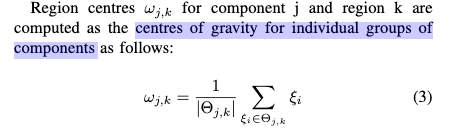

In [37]:
# Region centers
# centres of gravity for individual groups of components
from scipy import ndimage


def centre_of_gravity(discrete_component, bins):
    bins = len(np.unique(discrete_component))
    
    centres_of_gravity = []
    for region in range(bins):
        no_of_units_in_region = np.count_nonzero(discrete_component == region)



# https://stackoverflow.com/a/36957830
    for i in range(bins):
        matches = np.transpose((discrete_component == i).nonzero())

        #print(len(matches))
        #result = np.mean(matches, axis=0)
        result = np.mean(matches, axis=0)
        if(len(matches) != 0):
            centres_of_gravity.append(result)

    #print("len: " + str(len(centres_of_gravity)))
    return centres_of_gravity
    #plot_gravity(discrete_component,centres_of_gravity, color="viridis", interp=False, title="title")   


In [38]:

def distance(a, b, bins):
    res1 = 0
    res2 = 0
  


    for i in range(bins):
        res1 += abs(a[i] - b[i])
    for i in range(bins):
   
        res2 += abs(a[i] - b[bins -i -1])
        
    res1 = res1[0] + res1[1]
    res2 = res2[0] + res2[1]
  
        
    dist = min(res1,res2)
    
    
    
    return dist

In [39]:
# Note: m,n als Param nihct notwendig, wenn in SOMVIZ Klasse

def initAllSOMCoordinates(m,n):
    #result = [ [ (x , y) for x in range(n) ] for y in range(m) ] 
    result = []
    for y in range(m):
        for x in range(n):
            result.append((x,y))
    return result

def initAllSOMCoordinatesSumValues(m,n):
    result = []
    for y in range(m):
        for x in range(n):
            result.append(x+y)
    return result


def initAllSOMCoordinatesDiffValues(m,n):
    result = []
    for y in range(m):
        for x in range(n):
            result.append(x-y)
    return result
    #result = [ [ (x - y) for x in range(n) ] for y in range(m) ] 
    #return result

In [40]:
def getNeighbouringPoints(p):
   
    leftUpper  = (float(int(p[0])),float(int(p[1])))# "move" point coordinate to the closest unit lower left
    rightUpper = (float(leftUpper[0] + 1) , float(leftUpper[1]))
    leftLower  = (float(leftUpper[0])     , float(leftUpper[1] + 1))
    rightLower = (float(leftUpper[0] + 1 ), float(leftUpper[1] + 1))
    
    if (p[0] % 1 == 0):
        rightUpper = (leftUpper[0], leftUpper[1])
        rightLower = (leftUpper[0], leftUpper[1] + 1)
    
    if (p[1] % 1 == 0):
        leftLower  = (leftUpper[0], leftUpper[1])
        rightLower = (leftUpper[0] + 1, leftUpper[1])
        
    if (p[0] % 1 == 0 and p[1] % 1 == 0):
        rightLower = (leftUpper[0], leftUpper[1])
        

    neighbouringUnits = [leftUpper, leftLower, rightUpper, rightLower]

    return neighbouringUnits

In [41]:
def snapPoint(startPoint, line, currentPosition, direction, n, m, bins, allSOMCoordinates, allSOMCoordinatesSumValues, allSOMCoordinatesDiffValues):
    #bins = len(np.unique(discrete_component))
    
    result = [None] * len(line)
    
    # check, whether the current position exceed the line at one of the ends.
    if( (currentPosition == -1   and direction == -1) or
        (currentPosition == len(line) and direction == 1)):
        for i in range(len(line)):
            result[i] = (0,0)
        return result
    

    startPointCoordinatesSum        = int(startPoint[0] + startPoint[1])
    startPointCoordinatesDifference = int(startPoint[0] - startPoint[1])
    minDistance = float("inf") # set to infinity
    closestPoint = (None, None)
    
    for i in range(len(allSOMCoordinates)):
            #find units that are either in the same row (x equal), same column (y equal) or are in a diagonal (sum or diff values equal)
        if (allSOMCoordinates[i][0]            == startPoint[0] or
                allSOMCoordinates[i][1]        == startPoint[1] or
                allSOMCoordinatesSumValues[i]  == startPointCoordinatesSum or
                allSOMCoordinatesDiffValues[i] == startPointCoordinatesDifference):
              
            currentDistance = np.linalg.norm(allSOMCoordinates[i] - line[currentPosition])
    
            if (currentDistance < minDistance):
                closestPoint = allSOMCoordinates[i]
                minDistance  = currentDistance
                    
                    

    if (currentPosition > 1 and 
        line[currentPosition][0] == line[currentPosition - direction][0] and 
        line[currentPosition][1] == line[currentPosition - direction][1]):
        
        result = snapPoint(startPoint, line, currentPosition + direction, direction, n, m, bins, allSOMCoordinates, allSOMCoordinatesSumValues, allSOMCoordinatesDiffValues)
        result[currentPosition] = startPoint
    else:
      
        result = snapPoint(closestPoint, line, currentPosition + direction, direction, n, m, bins, allSOMCoordinates, allSOMCoordinatesSumValues, allSOMCoordinatesDiffValues)
        result[currentPosition] = closestPoint
        
    
    return result

In [154]:
# m, n kann raus

def snapping(centres_of_gravity, bins,allSOMCoordinates, allSOMCoordinatesSumValues, allSOMCoordinatesDiffValues):
    # 1. for each centre of gravity, find 4 neighbouring unit locations(points) (bins * 4 points)
    # 2. for each point, fix point and find snapped line 
    # 3. Choose closest line
    
    allSnappedLines = []
    for i in range(len(centres_of_gravity)):
        # get 4 neighb points
        neighbouringPoints = getNeighbouringPoints(centres_of_gravity[i])
        #print(neighbouringPoints)
        
        for neighbouringPoint in neighbouringPoints:
          
            forwardSegment      = snapPoint(neighbouringPoint, centres_of_gravity, i + 1, + 1, m,n, bins, allSOMCoordinates, allSOMCoordinatesSumValues, allSOMCoordinatesDiffValues)
            backwardSegment = snapPoint(neighbouringPoint, centres_of_gravity, i - 1, - 1, m,n, bins, allSOMCoordinates, allSOMCoordinatesSumValues, allSOMCoordinatesDiffValues)
         
        #then merge them to one line, and set the fixed point
            mergedLine = [None] * len(forwardSegment)
            for k in range(len(backwardSegment)):
                mergedLine[k] = (forwardSegment[k][0]+ backwardSegment[k][0],
                                 forwardSegment[k][1] + backwardSegment[k][1])
                
            mergedLine[i] = neighbouringPoint

            allSnappedLines.append(mergedLine)

           

        # Find forward line segment
        # Find backward line segment
        # Merge both segments and set fixed point
        # Do corner case stuff from java source code
        
    # find closest snapped line
    #print(len(allSnappedLines))
    minDist = float("inf")
    minDistLine = None
    for i in range(len(allSnappedLines)):
        currentLine = allSnappedLines[i]
        dist = distance(centres_of_gravity, currentLine, len(centres_of_gravity)) ##
        if (dist < minDist):
            minDist = dist
            minDistLine = currentLine
            
    #print(minDistLine)
    return minDistLine


In [155]:
def getDirection(currentPoint, nextPoint):
    dir = -1 ## maybe delete??
    
    # up
    if (currentPoint[0] == nextPoint[0] and currentPoint[1] > nextPoint[1]):
        dir = 0
        
    # right up
    if (currentPoint[0] < nextPoint[0] and currentPoint[1] > nextPoint[1]):
        dir = 1
        
    # right
    if (currentPoint[0] < nextPoint[0] and currentPoint[1] == nextPoint[1]):
        dir = 2
        
    # right down
    if (currentPoint[0] < nextPoint[0] and currentPoint[1] < nextPoint[1]):
        dir = 3
        
    # down
    if (currentPoint[0] == nextPoint[0] and currentPoint[1] < nextPoint[1]):
        dir = 4
        
    # left down
    if (currentPoint[0] > nextPoint[0] and currentPoint[1] < nextPoint[1]):
        dir = 5
        
    # left
    if (currentPoint[0] > nextPoint[0] and currentPoint[1] == nextPoint[1]):
        dir = 6
        
    # left up
    if (currentPoint[0] > nextPoint[0] and currentPoint[1] > nextPoint[1]):
        dir = 7
        
    return dir

In [156]:
def getDirectionArray(currentPoint, nextPoint):
    directions = [0,0,0,0,0,0,0,0] # 8x
    if(getDirection(currentPoint, nextPoint) == -1):
        return directions
    else:
        directions[getDirection(currentPoint, nextPoint)] = 1
        return directions

In [157]:
def getNextCoords(currentPoint, directions):
    #print("getNextCoord: " + str(currentPoint))
    nextPoint = list((currentPoint[0], currentPoint[1]))
    
    if(directions[0] == 1):
        nextPoint[0] = nextPoint[0] + 0
        nextPoint[1] = nextPoint[1] - 1
        
    if(directions[1] == 1):
        nextPoint[0] = nextPoint[0] + 1
        nextPoint[1] = nextPoint[1] - 1
        
    if(directions[2] == 1):
        nextPoint[0] = nextPoint[0] + 1
        nextPoint[1] = nextPoint[1] + 0
        
    if(directions[3] == 1):
        nextPoint[0] = nextPoint[0] + 1
        nextPoint[1] = nextPoint[1] + 1
        
    if(directions[4] == 1):
        nextPoint[0] = nextPoint[0] + 0
        nextPoint[1] = nextPoint[1] + 1
        
    if(directions[5] == 1):
        nextPoint[0] = nextPoint[0] - 1
        nextPoint[1] = nextPoint[1] + 1
        
    if(directions[6] == 1):
        nextPoint[0] = nextPoint[0] - 1
        nextPoint[1] = nextPoint[1] + 0
        
    if(directions[7] == 1):
        nextPoint[0] = nextPoint[0] - 1
        nextPoint[1] = nextPoint[1] - 1
        
    
    return tuple(nextPoint)

In [158]:
# merges to direction arrays. Hence, 100 and 001 become 101
def mergeArrays(a,b):
    
    result = [None] * len(a)
    
    for i in range(len(a)):
        if(a[i] == 1 or b[i] == 1):
            result[i] = 1
        else:
            result[i] = 0
    
    return result
        
    

In [159]:
def getAllDirections(component_lines):
    
    allDirections = {}
    
    for l in range(len(component_lines)):
        snappedLine = component_lines[l]
        allDirections[l] = {}
        outgoingLineTable = {}
        
        for m in range(len(snappedLine)):
            #print("m: " + str(m))
           
            currentPoint = snappedLine[m]
            backwardPoint = None
            backwardCoords = None
            forwardPoint = None
            forwardCoords = None
            forwardDirections = None
            backwardDirections = None
            
            #print(currentPoint)
            
            if(m > 0):
                backwardPoint = snappedLine[m - 1]
                
                backwardDirections = getDirectionArray(currentPoint, backwardPoint)
                backwardCoords     = getNextCoords(currentPoint, backwardDirections)
                
                #print("backwardsDirections m>0: " + str(backwardDirections))
                
                if (not (m < (len(snappedLine) - 1))):
                    if (currentPoint in outgoingLineTable):
                        outgoingLineTable[currentPoint] = mergeArrays(backwardDirections, outgoingLineTable[currentPoint])
                    else:
                        outgoingLineTable[currentPoint] =  backwardDirections
                        
                        
                        
            if (m < (len(snappedLine) - 1)):
                forwardPoint = snappedLine[m + 1]
                #forwardCoords = new Point2D.Double();
                forwardDirections = getDirectionArray(currentPoint, forwardPoint)
                forwardCoords = getNextCoords(currentPoint, forwardDirections)
                if (not (m > 0)):
                    if (currentPoint in outgoingLineTable):
                        outgoingLineTable[currentPoint] = mergeArrays(forwardDirections, outgoingLineTable[currentPoint])
                    else:
                        outgoingLineTable[currentPoint] =  forwardDirections
                        

            if (backwardPoint != None and forwardPoint != None):
                mergedDirections = mergeArrays(forwardDirections, backwardDirections)
                if (currentPoint in outgoingLineTable):
                    mergedDirections = mergeArrays(mergedDirections, outgoingLineTable[currentPoint])
               
                outgoingLineTable[currentPoint] =  mergedDirections
                
                    
                #then go for the forward stops and units in between stops
            if (forwardCoords != None):
                while (not(forwardPoint[0] == forwardCoords[0] and forwardPoint[1] == forwardCoords[1])): 
                    if (forwardCoords in outgoingLineTable):
                        outgoingLineTable[forwardCoords] = mergeArrays(forwardDirections, outgoingLineTable[forwardCoords])
                    else:
                        outgoingLineTable[forwardCoords] = forwardDirections
                           
                    forwardCoords = getNextCoords(forwardCoords, forwardDirections)
                    
            
                # then go for the backward stops and units in between stops
            if (backwardCoords != None):
                backwardCoords = getNextCoords(currentPoint, backwardDirections)
                while (not(backwardPoint[0] == backwardCoords[0] and backwardPoint[1] == backwardCoords[1])):
                    #print("backwPoint: " + str(backwardPoint))
                    #print("backwCoorda: " + str(backwardCoords))
                    #print("backwardDirect: " + str(backwardDirections))
                    if (backwardCoords in outgoingLineTable): 
                        #print("if")
                        outgoingLineTable[backwardCoords] = mergeArrays(backwardDirections, outgoingLineTable[backwardCoords])
                    else:
                        #print("else")
                        outgoingLineTable[backwardCoords] = backwardDirections     
                        
                    backwardCoords = getNextCoords(backwardCoords, backwardDirections)
                    
        #allDirections[l] = {}
        #allDirections[l][currentPoint] = outgoingLineTable[currentPoint]
        allDirections[l] = outgoingLineTable
        #print(outgoingLineTable[currentPoint])
 
    return allDirections
                    
                


In [160]:
def getUnitsWithStopOnThemAndHowMany(bins, allDirections, selectedComponents, binCentres):
    
    unitsWithStopsOnThemAndHowMany = {}
    for i_bin in range(bins):
        for i_components in range(len(allDirections)):
 
                
            if(len(binCentres[i_components]) > i_bin ):
                currentCentre = binCentres[i_components][i_bin]
                if (currentCentre in unitsWithStopsOnThemAndHowMany):
                    unitsWithStopsOnThemAndHowMany[currentCentre] = unitsWithStopsOnThemAndHowMany[currentCentre]+ 1
                else:
                    unitsWithStopsOnThemAndHowMany[currentCentre] = 1
          
    return unitsWithStopsOnThemAndHowMany;

In [161]:
def getComponentsInDirection(currentSOMUnit, i_direction, allDirections):
    componentsInDirection = [None] * len(allDirections)
    
    for i_components in range(len(allDirections)):
        outgoingLineTable = allDirections[i_components]
        if currentSOMUnit in outgoingLineTable:
            directions = outgoingLineTable[currentSOMUnit]
        else:
            directions = [0,0,0,0,0,0,0,0]
        
  
            
        componentsInDirection[i_components] = directions[i_direction]
        
    return componentsInDirection

In [162]:
def plot_gravity(matrix, component_lines, color="Viridis", interp = "best", title=""):
    
    lines = []
    for line in component_lines:
        # Convert list of points to dictionary
        x_coordinates = []
        y_coordinates = []
        for point in line:
            #x_coordinates.append(point[0])
            #y_coordinates.append(point[1])
            
            x_coordinates.append(point[0])
            y_coordinates.append(point[1])
        
        line_dict = {}
        line_dict["x"] = x_coordinates
        line_dict["y"] = y_coordinates
        
  
        # draw line
        lines.append(go.Scatter(line_dict,
                   mode='lines+markers',
                   #line_color='black', 
                    line_width=2.5))
   
    
  
    # draw heatmap
    heatmap = go.Heatmap(z=matrix, zsmooth=interp, showscale=False, colorscale=color)
    
    lines.append(heatmap)
    
    return go.FigureWidget(data= lines, layout=go.Layout(width=700, height=700,title=title, title_x=0.5,))


In [163]:
# check
def calculateArrayOverlaps(a,b):
    counter = 0
    for i in range(len(a)):
        if a[i] == b[i]:
            counter = counter +1
            
    return counter
        

In [164]:
def getIndexOfMaxValue(a):
    index = 0
    for i in range(len(a)):
        if (a[i] > a[index]):
            index = i
            
    return index

In [165]:
import numpy as np
from numpy import pi, sin, cos
import plotly.graph_objects as go

import math

def ellipse(x_center=0, y_center=0, ax1 = [[1, 0],[0,1]], a=1, b =1,  N=100):
    # x_center, y_center the coordinates of ellipse center
    # ax1 two orthonormal vectors representing the ellipse axis directions
    # a, b the ellipse parameters

    t = np.linspace(0, 2*pi, N)
    #ellipse parameterization with respect to a system of axes of directions a1, a2
    xs = a * cos(t)
    ys = b * sin(t)
    #rotation matrix
    R = np.array([ax1[0], ax1[1]]).T
    # coordinate of the  ellipse points with respect to the system of axes [1, 0], [0,1] with origin (0,0)
    xp, yp = np.dot(R, [xs, ys])
    x = xp + x_center
    y = yp + y_center
    return x, y

In [166]:
def createStations(allDirections, allSOMCoordinates,unitsWithStopsOnThemAndHowMany,lineOffset, lineThickness):

    upwards = [[0,1],[1,0]]
    downwards = [[0,-1],[-1,0]]
    right = [[1,0],[0,-1]]
    left = [[-1,0],[0,1]]

    topright = [[math.sqrt(2)/2, math.sqrt(2)/2],[math.sqrt(2)/2,-math.sqrt(2)/2]]
    topleft = [[-math.sqrt(2)/2, math.sqrt(2)/2],[math.sqrt(2)/2,math.sqrt(2)/2]]
    bottomleft = [[-math.sqrt(2)/2, -math.sqrt(2)/2],[-math.sqrt(2)/2,math.sqrt(2)/2]]
    bottomright = [[math.sqrt(2)/2, -math.sqrt(2)/2],[-math.sqrt(2)/2,-math.sqrt(2)/2]]    
    
    elipses = []
    for currentSOMUnit in allSOMCoordinates:
        
        directionsCache = [[None]* len(allDirections)]*8
        isStation= False
        
        for i_direction in range(8):
            componentInDirections = getComponentsInDirection(currentSOMUnit, i_direction, allDirections)
            directionsCache[i_direction] = componentInDirections
            
            numberOfLines = sum(list(componentInDirections))
            
            if (numberOfLines > 0):
                    #do we have more than one bincentre on this unit? if so it's gonna be a stop anyways
                if (currentSOMUnit in unitsWithStopsOnThemAndHowMany
                            and unitsWithStopsOnThemAndHowMany[currentSOMUnit] > 1):
                    isStation = True
                    continue;
                    
                matches = 0
                
                for i_direction_comparison in range(i_direction + 1,8) :
                    componentsInDirectionComparison = getComponentsInDirection(currentSOMUnit,i_direction_comparison,allDirections)
                      
                    if (len(allDirections) == calculateArrayOverlaps(componentInDirections, componentsInDirectionComparison)):
                        matches = matches +1
                    else: 
                        if (sum(list(componentsInDirectionComparison)) > 0):
                            isStation = True
                            continue
                        
                    
                if (matches > 1):
                    isStation = True
                    
                

        if (isStation):
      
            x = currentSOMUnit[0]
            y = currentSOMUnit[1]


            stationLayout = [ 0, 0, 0, 0 ]

            stationLayout[0] = max(sum(list(directionsCache[2])), sum(list(directionsCache[6])))
            stationLayout[1] = max(sum(list(directionsCache[3])), sum(list(directionsCache[7])))

            stationLayout[2] = max(sum(list(directionsCache[0])), sum(list(directionsCache[4])))
            stationLayout[3] = max(sum(list(directionsCache[1])), sum(list(directionsCache[5])))

            i_length = getIndexOfMaxValue(stationLayout)
            
            scale = 0.2
            
            
                  
            i_width = 0
            if (i_length == 0):
                i_width = 2
            elif (i_length == 2):
                i_width = 0
            elif (i_length == 1):
                i_width = 3
            elif (i_length == 3):
                i_width = 1
             
            leng = stationLayout[i_length]
            wid = max(1, stationLayout[i_width])
            x_offset = 0
            y_offset = 0
            len_draw = leng * .6

                /# % the rotation of the ellipse
            rotation = upwards
            #tmp

            if (i_length == 0): # 0 -- up
                rotation = upwards
            elif (i_length == 1): #// 1 -- right upper
                rotation = topleft
            elif (i_length == 2): # // 2 -- right
                rotation = right
            elif (i_length == 3): #// 3 -- right lower
                rotation = bottomleft
            
        
            

#https://i.imgur.com/O63B9j5.png

            xX, yY = ellipse(x_center=x, y_center=y,
                   ax1 = rotation,
                   a=.2, b =.1)
            #print("xx: " + str(xX))
            #print("yy: " + str(yY))
                  
            x_coordinates = []
            y_coordinates = []
           # x_coordinates.append(x - hhh * radius * radius * scale / 2)
           # y_coordinates.append(y - www * radius * radius * scale / 2)
            
            
            x_coordinates.append(xX)
            y_coordinates.append(yY)
        #x_coordinates.append(endPoint[0])
        #y_coordinates.append(endPoint[1])                    
            line_dict = {}
            line_dict["x"] = x_coordinates
            line_dict["y"] = y_coordinates
            #print(line_dict)
            #elipses.append(go.Scatter( mode='markers',
            #                                    x=[x],y=[y],
            #                                    marker=dict(color='White',size=15,line=dict(color='Black',width=2))))
            elipses.append(go.Scatter(  x=xX,
                                        y= yY,
                                        mode = 'lines',
                                        fill="toself",
                                        fillcolor= "White",
                                        line=dict(color="Black"))
            )
                

    return elipses

In [253]:
#createSnappedMetroLayout
import math
def plot_snapped(base,component_lines, bins, selectedComponents ,allSOMCoordinates ,color="Viridis", interp = "best", title=""):
    
    ############
    ############
    
    # TODO: Selected Components kann überall raus
    # TODO: Check line offset stuff
    # TODO: Color Zeug muss noch sitzen
    # TODO: Legende fixen
    lineThickness = 2.5
  
    lineOffsetIsThisFractionOfRadius = 0.5

    # shifts between parallel metro lines
    #lineOffset = lineThickness / lineOffsetIsThisFractionOfRadius
    lineOffset = 0.08
    title= "MetroMaps"
    
    colorDict = {}
    colorDict[0] = "red"
    colorDict[1] = "blue"
    colorDict[2] = "yellow"
    colorDict[3] = "green"
    colorDict[4] = "brown"
    colorDict[5] = "coral"
    colorDict[6] = "darkkhaki"
    colorDict[7] = "darkmagenta"
    colorDict[8] = "darkolivegreen"
    colorDict[9] = "darkorange"
    colorDict[10] = "darkorchid"
   
    ############
    ############
   

    
    allDirections = getAllDirections(component_lines)
    unitsWithStopsOnThemAndHowMany = getUnitsWithStopOnThemAndHowMany(bins, allDirections, selectedComponents, component_lines)
 
    lines= []
    stations=[]
    
    for currentSOMUnit in allSOMCoordinates:
        for i_direction in range(8):
            #print("i_direction: " + str(i_direction))
            compCounter = 0
            componentsInDirection = getComponentsInDirection(currentSOMUnit, i_direction, allDirections)
            #print("currentUnit: " + str(currentSOMUnit))
            #print("componentsInDirection: " + str(componentsInDirection))
            numberOfLines = sum(list(componentsInDirection))
            #print("sum: " + str(numberOfLines))
            multiLineOffset = (numberOfLines - 1) * lineOffset / 2
            xDir = 0
            yDir = 0
            xOffset = 0
            yOffset = 0
            
      
            for i_components in range(len(componentsInDirection)):
                
                if (componentsInDirection[i_components] == 0):
                    continue
                   
               
                if (i_direction == 0):
                    xDir = 0
                    yDir = -1
                    xOffset = lineOffset * compCounter - multiLineOffset
                    yOffset = 0
                    
                if (i_direction == 1):
                    xDir = 1
                    yDir = -1
                    xOffset = (lineOffset * compCounter - multiLineOffset) / math.sqrt(2)
                    yOffset = (lineOffset * compCounter - multiLineOffset) / math.sqrt(2)
                    
                if (i_direction == 2):
                    #print("dir 2")
                    xDir = 1
                    yDir = 0
                    xOffset = 0
                    yOffset = lineOffset * compCounter - multiLineOffset
                    
                if (i_direction == 3):
                    xDir = 1
                    yDir = 1
                    xOffset = +(lineOffset * compCounter - multiLineOffset) / math.sqrt(2)
                    yOffset = -(lineOffset * compCounter - multiLineOffset) / math.sqrt(2)
                    
                    #Finally, draw the line
                startPoint = (currentSOMUnit[0] + xOffset, currentSOMUnit[1]+ yOffset)
                endPoint = (currentSOMUnit[0] + xDir + xOffset, currentSOMUnit[1] + yDir + yOffset)
                compCounter = compCounter +1

                x_coordinates = []
                y_coordinates = []
                x_coordinates.append(startPoint[0])
                y_coordinates.append(startPoint[1])
                x_coordinates.append(endPoint[0])
                y_coordinates.append(endPoint[1])                    
                line_dict = {}
                line_dict["x"] = x_coordinates
                line_dict["y"] = y_coordinates
                lines.append(go.Scatter(line_dict,
                                 mode='lines',
                                 line_color=colorDict[i_components],         
                                 line_width=2.5))
   
                    
                   
                #handle stops (i.e. region centres)
                for i_bin in range(bins):
                    #print("first enter")
                       #if(len(binCentres[i_components]) > i_bin ):
                    if(len(component_lines[i_components]) > i_bin): # TODO check
                     #   print("enter")
                        currentCentre = component_lines[i_components][i_bin]
                    
                    # draw no stops if this is gonna be a station anyways (stops with more than two centres on them
                    # are stations)
                        if (not(currentCentre[0] == currentSOMUnit[0] and currentCentre[1] == currentSOMUnit[1])
                                or currentSOMUnit in unitsWithStopsOnThemAndHowMany
                                and unitsWithStopsOnThemAndHowMany[currentSOMUnit] > 1 # todo
                                or yOffset == 0
                                and xOffset == 0 and numberOfLines > 1):
                            #print("continue")
                            continue
                        
                        #x = (currentCentre[0] * unitWidth + unitWidth / 2) # int
                        #y = ((currentCentre[1] + yOffset) * unitHeight + unitHeight / 2) # int
                        x = currentCentre[0]
                        y = currentCentre[1]
                   
                        x_coordinates = []
                        y_coordinates = []
                        x_coordinates.append(x)
                        y_coordinates.append(y)
                                      
                        line_dict = {}
                        line_dict["x"] = x_coordinates
                        line_dict["y"] = y_coordinates
                        stations.append(go.Scatter( mode='markers',
                                                x=[x],y=[y],
                                                marker=dict(color='Black',size=7,line=dict(color='Black',width=1))))
                
            
        
        

        
        
    bigStops = createStations(allDirections, allSOMCoordinates,unitsWithStopsOnThemAndHowMany, lineOffset, lineThickness)
    #print(bigStops)
    
            # draw heatmap
    heatmap = go.Heatmap(z=base, zsmooth=interp, showscale=False, colorscale=color)
    #print("lines: " + str(lines))
    
    # To draw in foreground
    for station in stations:
        #print("station: " +str(station))
        lines.append(station)
        
    #print(metroStops)
    for metroStation in bigStops:
        #print(metroStation)
        lines.append(metroStation)
        
    lines.append(heatmap)
    
    
    return go.FigureWidget(data= lines, layout=go.Layout(width=700, height=700,title=title, title_x=0.5, showlegend= False))

    

In [254]:
# weights, m, n kann später weg, wenn wir es in die Klasse setzen, muss dann durch self.weights etc. ersetzt werden.

def metro_map (weights, m, n, bins, components= None, background_component_plane= 0, interp = 'best'):
    
    # Initialize the Lookup SOMs
    allSOMCoordinates           = initAllSOMCoordinates(m,n) # TODO: Maybe !?
    allSOMCoordinatesSumValues  = initAllSOMCoordinatesSumValues(m,n)
    allSOMCoordinatesDiffValues = initAllSOMCoordinatesDiffValues(m,n)
    
    
    base = []
    
    # consider all components for the case there are no components specified
    if components == None:
        components = range(weights.shape[1])
        
    component_lines = []
    for i in components:
        comp = weights[:,i].reshape(-1,n)

        discrete_component = discretize(comp, bins)
        if (i == background_component_plane):
            base = discrete_component
        centres_of_gravity = centre_of_gravity(discrete_component,bins)
        #snapped_centres = centres_of_gravity
        #print("centr: " + str(centres_of_gravity))
        snapped_centres    = snapping(centres_of_gravity, bins, allSOMCoordinates, allSOMCoordinatesSumValues, allSOMCoordinatesDiffValues)
        
        snap = [(t[1], t[0]) for t in snapped_centres]
        component_lines.append(snap)
        #component_lines.append(snapped_centres)
        
        if (len(base) == 0):
            base = discrete_component

    return plot_snapped(base, component_lines, bins, components,allSOMCoordinates, interp = interp)
    
    
        


In [258]:
smap = SOMToolBox_Parse(path_weight_file)
smap, sdim, smap_x, smap_y = smap.read_weight_file()

weights = smap.values.reshape(-1,sdim)
n = smap_x
m = smap_y


viz_SOMToolBox = SomViz(smap.values.reshape(-1,sdim), smap_y, smap_x)

um3 = metro_map(weights,m = m, n = n, components = components_selected, bins = no_of_bins, background_component_plane = component_for_background_vis, interp = interpolate )
um3

FigureWidget({
    'data': [{'line': {'color': 'blue', 'width': 2.5},
              'mode': 'lines',
         …